En este notebook investigamos distintas métricas posibles para el modelo, describiendolas brevemente, argumentando por qué podrían ser adecuadas y mostrando cómo se implementan 

# Preambulo: preparar los datos y el modelo elegido

In [2]:
import pandas as pd
import numpy as np

import json
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = build_dataset()

tabla_train=pd.DataFrame.from_dict(X_train, orient='columns') #las keys son las columnas

tabla_train=(tabla_train[['title','seller_id','price','warranty','listing_type_id','initial_quantity','sold_quantity','category_id','condition']]
        .astype({'seller_id':'object'}))

tabla_test=pd.DataFrame.from_dict(X_test, orient='columns')[['title','seller_id','price','warranty','listing_type_id','initial_quantity','sold_quantity','category_id']] #las keys son las columnas


In [3]:
def label_encoder(s):
    if s=='new':
        return 1
    else:
        return 0

In [4]:
y_train_encoded=np.array(list(map(label_encoder,y_train)))

y_test_encoded=np.array(list(map(label_encoder,y_test)))

In [5]:
# datos

#texto
import nltk
from nltk.corpus import stopwords

sw=stopwords.words('spanish')
sw.remove('sin')
sw.remove('con')

from sklearn.feature_extraction.text import CountVectorizer
vectorizador_bow=CountVectorizer(stop_words=sw)

x_train_bow=vectorizador_bow.fit_transform(tabla_train['title'])

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_bow)

x_test_bow = vectorizador_bow.transform(tabla_test['title'])
x_test_tfidf = tfidf_transformer.transform(x_test_bow)


#features
 #sumamos uno para que los codigos empiecen en 1 y no en 0
cat_codes=tabla_train['category_id'].astype('category').cat.codes + 1
list_codes=tabla_train['listing_type_id'].astype('category').cat.codes + 1


from collections import defaultdict #le damos un valor por defecto

encoder_cat = {key:value for (key,value) in np.array([tabla_train['category_id'],cat_codes]).T}
encoder_cat=defaultdict(int ,encoder_cat)
decoder_cat = {value:key for (key,value) in encoder_cat.items()}
decoder_cat=defaultdict(int ,decoder_cat)

encoder_type = {key:value for (key,value) in np.array([tabla_train['listing_type_id'],cat_codes]).T}
encoder_type=defaultdict(int ,encoder_type)
decoder_type = {value:key for (key,value) in encoder_cat.items()}
decoder_type=defaultdict(int ,decoder_type)

x_train_sc = (
            np.array([tabla_train['category_id'].map(encoder_cat),
                      tabla_train['listing_type_id'].map(encoder_type)])
            ).T

x_train_features = pd.concat([pd.DataFrame(x_train_sc),tabla_train['initial_quantity'], tabla_train['sold_quantity']],axis=1).to_numpy()


x_test_sc = (np.array([#tabla_test['seller_id'].map(encoder_seller,), 
                       tabla_test['category_id'].map(encoder_cat),
                      tabla_test['listing_type_id'].map(encoder_type)]).T
            )
x_test_features = pd.concat([pd.DataFrame(x_test_sc),tabla_test['initial_quantity'], tabla_test['sold_quantity']],axis=1).to_numpy()


In [6]:
from scipy.sparse import coo_matrix, hstack
x_train = hstack([x_train_tfidf,x_train_features])
x_test = hstack([x_test_tfidf,x_test_features])

In [7]:
x_train

<90000x78505 sparse matrix of type '<class 'numpy.float64'>'
	with 822410 stored elements in COOrdinate format>

In [8]:
x_test

<10000x78505 sparse matrix of type '<class 'numpy.float64'>'
	with 86428 stored elements in COOrdinate format>

In [9]:
# modelo elegido
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 40).fit(x_train, y_train_encoded)

In [10]:
y_pred=tree.predict(x_test)

# Metricas

## Accuracy

In [13]:
acc_tree= (y_pred == y_test_encoded).sum()/len(y_test)

In [14]:
acc_tree

0.8655

## F_beta score

La accuracy no siempre es una métrica buena, por ejemplo cuando las clases son desbalanceadas: si el 90% de los datos son de la clase c, entonces un clasificador que prediga siempre "c" tiene de primera un 90% de accuracy pero no sirve para nada realmente. Surgen otras métricas como:

Precision: proporción de los datos predichos como positivos, que realmente lo son.


Recall: proporción de los datos que realmente son positivos, que fueron predichos como tal.


Si en Mercado Libre se quisiera encontrar productos nuevos, por ejemplo para ofrecerles a esos vendedores un servicio de garantía de un tercero asociado con MeLi por decir algo, entonces la precision con "new" como clase positiva sería una buena métrica.


El $F_\beta-score$ surge de querer lograr un balance entre la recall y la precision (en general hay un trade-off entre ambas). 
$F_\beta = (1+\beta^2)\frac{precision \times recall}{\beta^2 precision + recall}$
con esta formulación (la usada en sklearn) la recall es $\beta$ veces tan importante como la precision.

Tanto en el conjunto de entrenamiento como en el test hay un poco más de productos nuevos que usados, para compensar esto utilizar la $F\beta$ con $\beta=2$ es una opción, con "used" como la clase positiva. Así contemplamos el estar clasificando bien suficientes elementos de esta clase (que es la que sale perjudicada si solo se ve la accuracy) pero sin descuidar demasiado la precision (por eso usaríamos la $F_\beta$ y no directamente la recall).

In [36]:
from sklearn.metrics import fbeta_score


fbeta_score(y_true=y_test_encoded, y_pred=y_pred,beta=2,labels=[0,1])

0.8544078528342887

## AUC ROC

$TPR= TP/(TP+FN)$ y $FPR=FN/(TN+FP)$ la curva roc esta definida por el valor de estas dos cantidades en todos los "umbrales" (treshold) posibles, o sea en la probabilidad minima que el modelo requiere para clasificar una observacion como positiva.

El valor del area bajo esta curva (AUC) habla de qué tan bien el modelo distingue casos positivos de negativos. Si las clases estan muy desbalanceadas el modelo aprende un favortismo por una de ellas y no va a poder distinguir bien. Además para el auc-score no hay una clase más importante que la otra, lo que medimos es que tan bien las podemos separar.

En nuestro problema los datasets estan bien balanceados y no nos interesa predecir mejor productos nuevos o predecir mejor productos usados, sino ambos por igual, por eso esta es una buena métrica para el modelo.

In [78]:
y_pred_prob=tree.predict_proba(x_test)

In [79]:
from sklearn.metrics import roc_auc_score

#roc score con positive=new, hay que darle probabilidades, no las predicciones
roc_auc_score(y_true=y_test_encoded, y_score=y_pred_prob[:,1],labels=[1,0])

0.8746367046338008

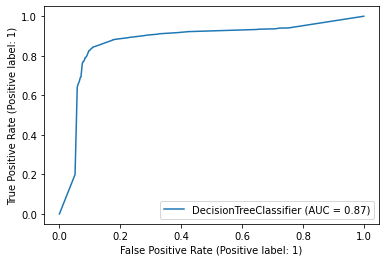

In [45]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(tree, x_test, y_test_encoded,)  

## metrica personalizada

Una métrica es una forma de medir el desempeño de un modelo y es un insumo para *comparar* modelos entre sí.
Además de las métricas de uso general como las anteriores, siempre se pueden crear particulares que dependen del problema y de qué es lo importante para el cliente/negocio/aplicación.

Por ejemplo en MeLi más que interesarse estrictamente por la cantidad de productos nuevos o usados que se clasifican bien, puede ser más interesante saber el equivalente en cantidad de dinero que circula por la plataforma que ha sido clasificada bien, o bien la proporción de "dinero bien clasificado" que circula.

Podemos calcular esto a partir de los precios

In [69]:
tabla_test['correct']= (y_pred == y_test_encoded)

In [ ]:
total=tabla_test['price'].sum()
porcentajes_plata=tabla_test.groupby(by='correct')['price'].sum()/total

In [75]:
porcentajes_plata

correct
False    0.146382
True     0.853618
Name: price, dtype: float64

In [76]:
metrica_personalizada=porcentajes_plata[1]

In [77]:
metrica_personalizada

0.8536176073920978

# Conclusión

Considerando lo anterior, si hay que elegir una considero que AUC-ROC score es la que mejor se ajusta a nuestro problema, por lo dicho sobre nuestros datasets y de que no nos importa más una clase que la otra. La performance con esta métrica es un poco mejor que con la accuracy, seguramente por esto que mencionamos.